In [5]:
from datetime import datetime, timedelta
import pytz
import math
import pylab as plt

import pandas as pd
import numpy as np

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

from extractor import WeatherExtractor, Extractor, Period
sampling_interval = '15min'
import tqdm

%matplotlib widget
from plotter import Plot

from inversegreyboxmodel import Learner

import openpyxl


# TODO: get list of pseudonyms, (valid) dates and reference parameters from Excel file  
homes =  [817341, 886307, 873985]

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.5065500000, 6.0996100000

#timezone: 
timezone_homes = 'Europe/Amsterdam'

# first test just a short timeseries
start = pytz.timezone(timezone_homes).localize(datetime(2021, 12, 20))
end = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 18))

# date and times of seemingly valid periods for short set of 3 
# 886307	2021-12-19 18:55	2022-03-17 09:37
# 873985	2021-12-20 12:54	2022-03-17 17:54
# 817341	2022-01-14 20:27	2022-03-17 18:15

    
# utimately: #min, max dates of the analysis
# start = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 21))
# end = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 12)
# homes = [815925, 817341, 857477, 873985, 879481, 
#          895671, 864296, 845997, 881611, 822479, 
#          831062, 830088, 811308, 809743, 829947, 
#          803422, 886307, 846697, 845966, 839440, 
#          805164, 899510, 897349]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#check whether the datetime object is properly timezone-aware
start

datetime.datetime(2021, 12, 20, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [7]:
#check whether the datetime object is properly timezone-aware
end

datetime.datetime(2022, 1, 18, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)

In [8]:
%%time 
%autoreload 2
# get geospatially interpolated weather from KNMI
# for Twomes, the Weather for all all homes studies can be approached by a single location
# get the dataframe only once for all homes to save time

df_weather = WeatherExtractor.get_interpolated_weather_nl(start, end, lat, lon, timezone_homes, sampling_interval)

Resampling weather data...
CPU times: user 43.8 ms, sys: 6.18 ms, total: 50 ms
Wall time: 48.6 ms


In [9]:
df_weather

,outdoor_temp_degC,windspeed_m_per_s,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,effective_outdoor_temp_degC
2021-12-20 00:00:00+01:00,6.021051,1.604638,-1.976263e-323,-5.434722e-323,4.951292
2021-12-20 00:15:00+01:00,5.981809,1.604638,-1.976263e-323,-5.434722e-323,4.912050
2021-12-20 00:30:00+01:00,5.942567,1.604638,-1.976263e-323,-5.434722e-323,4.872808
2021-12-20 00:45:00+01:00,5.903324,1.604638,-1.976263e-323,-5.434722e-323,4.833566
2021-12-20 01:00:00+01:00,5.868830,1.583000,-1.976263e-323,-5.434722e-323,4.813496
...,...,...,...,...,...
2022-01-17 23:00:00+01:00,5.782430,2.021638,-1.976263e-323,-5.434722e-323,4.434672
2022-01-17 23:15:00+01:00,5.808976,2.086552,-1.976263e-323,-5.434722e-323,4.417941
2022-01-17 23:30:00+01:00,5.835521,2.151465,-1.976263e-323,-5.434722e-323,4.401211
2022-01-17 23:45:00+01:00,5.862066,2.216379,-1.976263e-323,-5.434722e-323,4.384480


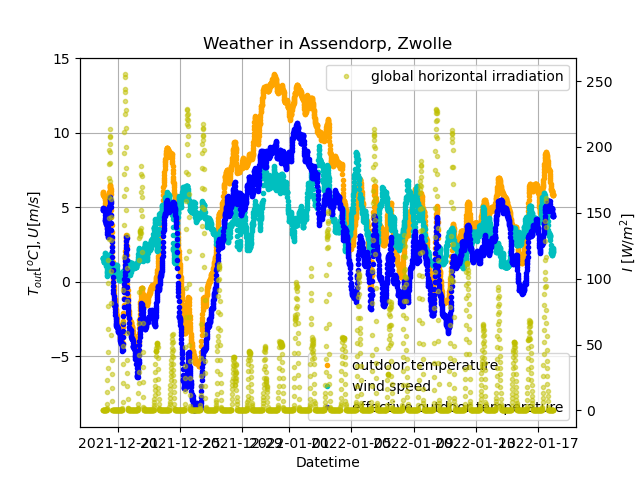

In [10]:
# plot temperature data

Plot.weather_and_other_temperatures('Weather in Assendorp, Zwolle', df_weather)

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [ ]:
# get interpolated data from the Twomes database and combine with weather data already obtained
df_data_homes = Extractor.get_interpolated_twomes_data(homes, start, end, timezone_homes, sampling_interval, df_weather)

Retrieving data for pseudonyms...


 33% 1/3 [01:22<02:44, 82.30s/it]

In [ ]:
# see what the extracted and interpolated data looks like
df_data_homes

In [ ]:
# how to select data from a single home
df_data_homes[df_data_homes['homepseudonym'] == 817341]

In [ ]:
# plot temperature data of multiple homes from an array 

for home_id in homes:
    df_data_one_home = df_data_homes[df_data_homes['homepseudonym'] == home_id]
    Plot.weather_and_other_temperatures(home_id, df_data_one_home, ['indoor_temp_degC'])

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks


In [ ]:
#plot a series of weeks for all homes
plt.ioff()

for home_id in homes:
    df_data_one_home = df_data_homes[df_data_homes['homepseudonym'] == home_id]
    for moving_horizon_start in pd.date_range(start=start, end=end, inclusive='left', freq='7D'):
        moving_horizon_end = min(end, moving_horizon_start + timedelta(days=7))
        df_moving_horizon = df_data_one_home[moving_horizon_start:moving_horizon_end]
        Plot.weather_and_other_temperatures(home_id, df_moving_horizon, ['indoor_temp_degC'])

plt.ion()  
    

In [ ]:
%%time 
%autoreload 2

# uncomment lines below if you need something other than the defaults
# homes_to_analyze = [817341]
# start_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
# end_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 9))
moving_horizon_duration_d = 3
df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes, moving_horizon_duration_d, homes_to_analyze, start_analysis_period, end_analysis_period, showdetails=True)

# or: uncomment lines below if you want to analyse all homes for all periods with a default moving horizon duration of 7 days
# df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes)

df = df_results
for col in df.select_dtypes(['datetimetz']).columns:
    df[col] = df[col].dt.tz_localize(None)
df.to_excel('result.xlsx')

In [ ]:
#show the results
df_results